<a href="https://colab.research.google.com/github/BillWENZE/BillWENZE/blob/main/MLP_Hands_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron - Excess Return Forecasts

**Objectives**

* Train Feed-Forward Networks
  * Early Stopping
  * Activation Functions
  * Loss Functions
  * Optimizers
  * Shallow vs. Deep
* Forecast Excess Returns

## Data Import - Goyal Welch Excess Return Predictors

In [1]:
!gdown --id 1OMWYlG7JXHN-PeBvQ1UBmfmlIuZP80fO

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OMWYlG7JXHN-PeBvQ1UBmfmlIuZP80fO
To: /content/merged_data.csv
100% 981k/981k [00:00<00:00, 98.2MB/s]


In [2]:
! pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00


## Library Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import Dense, Normalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

In [4]:
df = pd.read_csv('merged_data.csv')

In [5]:
df.set_index('Date',inplace=True)

## Data Transformations

In [6]:
Y = df.loc['1959-04-01':,'excess_returns'].reset_index(drop=True)
X = df.loc[:'2020-11-01', df.columns!='excess_returns'].reset_index(drop=True)

In [7]:
df1=pd.concat([Y,X],axis=1)
df1.set_index(df.reset_index().iloc[1:,0],inplace=True)

In [8]:
Y = df1['excess_returns']
X = df1.drop('excess_returns',axis=1)

Generating the splits- We are going to use Robust Scaler and use a very specific strategy in scaling our variables.

In [9]:
Y

Date
1959-04-01    0.038054
1959-05-01    0.021431
1959-06-01   -0.003225
1959-07-01    0.032004
1959-08-01   -0.012976
                ...   
2020-08-01    0.071968
2020-09-01   -0.038251
2020-10-01   -0.026509
2020-11-01    0.109303
2020-12-01    0.041473
Name: excess_returns, Length: 741, dtype: float64

In [10]:
scaler=RobustScaler(quantile_range=(10,90))

In [11]:
X_train =scaler.fit_transform(X.loc[:'2018'])
X_valid = scaler.transform(X.loc['2019-01-01':'2019-12-01'])

In [12]:
X_test_0 = scaler.fit_transform(X.loc[:'2019'])
X_test = scaler.transform(X.loc['2020-01-01':'2020-12-01'])

In [14]:
y_train=y.loc[:'2018']
y_valid=y.loc['2019-01-01':'2019-12-01']
y_test=y.loc['2020-01-01':'2020-12-01']

NameError: name 'y' is not defined

In [15]:
X

,CPIAUCSL,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCOLNVHFNM,DTCTHFNM,INVEST,D12,E12,b/m,lty,ntis,ltr,svar
Date,,,,,,,,,,,,,,,,,,,,,
1959-04-01,-0.000690,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,...,0.004929,0.004138,-0.014792,1.770000,3.110000,0.516860,0.0403,0.024984,0.0017,0.000492
1959-05-01,0.001380,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,...,0.012134,0.006734,0.024929,1.776670,3.206670,0.498597,0.0414,0.024361,-0.0117,0.000493
1959-06-01,0.001723,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,...,0.002828,0.002020,-0.015342,1.783330,3.303330,0.483077,0.0417,0.025887,-0.0005,0.000428
1959-07-01,0.000339,0.003102,0.002974,0.003708,-0.000051,0.009064,0.001144,0.007034,0.007126,-0.004768,...,0.009726,0.009007,-0.012252,1.790000,3.400000,0.483219,0.0419,0.026882,0.0010,0.000915
1959-08-01,-0.001034,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008247,0.013056,...,-0.004631,-0.001000,0.029341,1.796670,3.410000,0.460823,0.0417,0.027141,0.0060,0.000488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-0.000097,0.005988,0.009918,0.014326,0.026017,0.013834,0.040064,0.042545,0.047389,0.041804,...,-0.006217,0.000561,-0.003085,59.406020,98.893333,0.253848,0.0062,-0.011998,0.0287,0.001608
2020-09-01,-0.001624,-0.032790,0.010429,0.006836,0.002130,0.008330,0.010522,0.013035,0.012572,0.007465,...,-0.005675,-0.002656,-0.016114,59.128628,98.556667,0.235975,0.0065,-0.008504,-0.0349,0.000743
2020-10-01,-0.001046,0.005666,0.009884,0.013125,0.006045,0.020661,-0.003034,-0.005733,-0.010124,-0.014893,...,-0.001469,0.002209,-0.001093,58.851237,98.220000,0.241482,0.0068,-0.005698,0.0080,0.004907


# Building the Neural Network

## Some Universal Parameters

In [16]:
# Set the Patience Level of Early Stopping
# Iterations increase with patience

# Number of epochs with no improvement after which training will be stopped.


#patience = 2
#patience = 3
#patience = 4
#patience = 5
#patience = 6
#patience = 7
#patience = 8
#patience = 9
patience = 50

early_stop = EarlyStopping(monitor='val_loss',patience=patience)

In [17]:
### Select Activation Function by Uncommenting ###

#act_fn = 'elu'       # Exponential Linear Unit
#act_fn = 'gelu'      # Gaussian error linear unit
#act_fn = 'selu'      # Scaled Exponential Linear Unit
act_fn = 'relu'      # Rectified Linear Unit
#act_fn = 'sigmoid'   # Sigmoid activation

In [18]:
### Select Loss Function by Uncommenting ###

#loss = 'mean_squared_error' # Mean Squared Error Loss
loss = 'huber' #Huber Loss
#loss = 'mean_absolute_error

In [19]:
### Select Optimizer by Uncommenting ###

#optimizer = 'Adadelta' # Adadelta
optimizer = 'adam' # Adam
#optimizer = 'SGD'  # Stochastic Gradient Descent

## Neural Net with 1 Layer - Shallow Net - NN(1)

In [20]:
#neurons = 3
#neurons = 6
#neurons = 9
neurons = 119

In [21]:
epochs=500
normalizer = Normalization(axis=-1)
model = Sequential(normalizer) # scale the input variables
model.add(Dense(neurons, activation=act_fn)) #define a single dense layer
model.add(Dense(1)) # output layer
model.compile(loss=loss, optimizer=optimizer)
model.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs,callbacks=[early_stop]) #fit the model

NameError: name 'y_train' is not defined

In [ ]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 25ms/step - loss: 0.2809


0.2808939516544342

In [ ]:
y_pred_nn1 = model.predict(X_test)

Text(0.5, 1.0, 'Shallow NeuralNet Forecast')

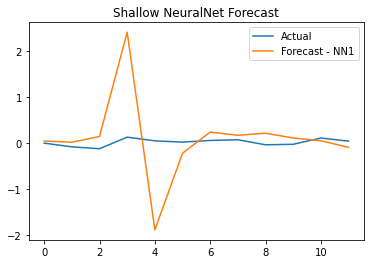

In [ ]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,y_test)
#plt.xlabel('date')
plt.plot(X_grid,y_pred_nn1)
plt.legend(('Actual','Forecast - NN1'))
plt.title('Shallow NeuralNet Forecast')
#plt.savefig('Shallow NeuralNet Test')

## Neural Net with 3 Layers

In [ ]:
start_time = time.time()
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn = Sequential(normalizer) # scale the input variables
model_dnn.add(Dense(119, activation=act_fn)) #define first dense layer with 119 neurons
model_dnn.add(Dense(50,  activation=act_fn)) #define first dense layer with 50 neurons
model_dnn.add(Dense(25,  activation=act_fn)) #define second dense layer with 25 neurons
model_dnn.add(Dense(1)) # output layer
model_dnn.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs,callbacks=[early_stop]) #fit the model
end_time = time.time()
end_time - start_time

In [ ]:
model_dnn.evaluate(X_test,y_test)

1/1 [==============================] - 0s 23ms/step - loss: 0.0150


0.01504131406545639

In [ ]:
y_pred_nn3 = model_dnn.predict(X_test)

Text(0.5, 1.0, 'NeuralNet Test data')

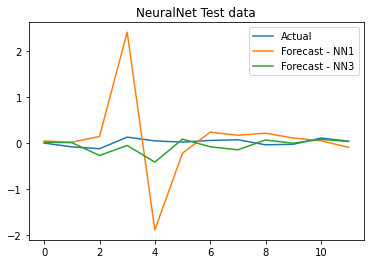

In [ ]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,y_test)
#plt.xlabel('date')
plt.plot(X_grid,y_pred_nn1)
plt.plot(X_grid,y_pred_nn3)
plt.legend(('Actual','Forecast - NN1','Forecast - NN3'))
plt.title('NeuralNet Test data')
#plt.savefig('NeuralNet Test')

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    normalizer = Normalization(axis=-1)
    model = Sequential(normalizer)
    model = keras.Sequential()
    model.add(keras.layers.Dense(hp.Choice('units', [8,16,32,64]),activation=hp.Choice('activation',['relu','gelu','elu'])))
    model.add(keras.layers.Dense(hp.Choice('units', [8,16,32,64]),activation=hp.Choice('activation',['relu','gelu','elu'])))
    model.add(keras.layers.Dense(hp.Choice('units', [8,16,32,64]),activation=hp.Choice('activation',['relu','gelu','elu'])))
    model.add(keras.layers.Dense(1))
    model.compile(loss=hp.Choice('loss',['mean_squared_error','huber','mean_absolute_error']), optimizer='adam')
    return model

In [ ]:
tuner=kt.RandomSearch(build_model,objective='val_loss',max_trials=50)
tuner.search(X_train,y_train,validation_data=(X_valid,y_valid),epochs=200)
best_hps=tuner.get_best_hyperparameters(num_trials=50)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, validation_split= 0 , epochs=200, verbose=0)